# International Conference on Computer Security in the Nuclear World: Security for Safety.  19-23 June 2023, Vienna, Austria.

## TECHNICAL SESSION – TH5, CN313-172

This notebook shows a practical application of clustering on simulations of http accesses to a server.  Among the normal accesses there are attempted attacks and you can try to find them. It is sufficiently guided that you don't need much knowledge in Machine Learning, just a little bit of Python and a Scikit-learn instalation.


In [199]:
# Some imports, scikit-learn it's mandatory

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import silhouette_score
from sklearn import preprocessing
sns.set_theme()

In [200]:
# Auxiliary functions

def gen_features_df(df):
    '''
    It creates new features on the data, in particular four new features that summarize all the access codes 
    from the server and a conversion into kbytes of all the bytes sended.
    
    You could try to generate new features in here
    '''
    df['1xx_count'] = df['101_count']
    df['2xx_count'] = df['200_count'] + df['204_count'] + df['206_count']
    df['3xx_count'] = df['301_count'] + df['302_count'] + df['303_count'] + df['304_count']
    df['4xx_count'] = df['400_count'] + df['401_count'] + df['403_count'] + df['404_count'] + df['405_count'] + df['406_count'] + df['408_count'] + df['414_count'] + df['429_count']+ df['499_count']
    df['5xx_count'] = df['500_count'] + df['502_count'] + df['504_count']

    df['total_kbytes_sent'] = df['total_bytes_sent'].div(1024)

    return df

Let's read the logs and generate the new features

In [201]:
df_LOGS = pd.read_csv(r"./data/new_features/app.cnea.gob.ar_NGINX_DMZ_1_20221024_20221024.csv")

# All the columns of the file (keep in mind for later)
print(list(df_LOGS.columns))

['hosts', 'hosts_count', 'start_time', 'ip', 'sql_count', 'url_enc_count', '101_count', '200_count', '204_count', '206_count', '301_count', '302_count', '303_count', '304_count', '400_count', '401_count', '403_count', '404_count', '405_count', '406_count', '408_count', '414_count', '429_count', '499_count', '500_count', '502_count', '504_count', 'total_ua', 'total_bots', 'total_req', 'total_bytes_sent', 'full_url', 'full_useragent']


In [202]:
#generate new features
df_LOGS = gen_features_df(df_LOGS)

#let's take a look
df_LOGS.head()

,hosts,hosts_count,start_time,ip,sql_count,url_enc_count,101_count,200_count,204_count,206_count,...,total_req,total_bytes_sent,full_url,full_useragent,1xx_count,2xx_count,3xx_count,4xx_count,5xx_count,total_kbytes_sent
0,['app.cnea.gob.ar'],1,2022-10-24 10:54:36-03:00,10.73.150.78,0,0,0,0,0,0,...,3,720,get /test/ http/1.1\nget /favicon.ico ht...,['Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv...,0,0,0,3,0,0.703125
1,['app.cnea.gob.ar'],1,2022-10-24 10:55:17-03:00,10.73.150.78,0,0,0,0,0,0,...,1,240,get /test/index.html http/1.1,['Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv...,0,0,0,1,0,0.234375
2,['app.cnea.gob.ar'],1,2022-10-24 10:55:54-03:00,10.73.150.78,0,0,0,2,0,0,...,2,8795,get /index.html http/1.1\nget /icon...,['Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv...,0,2,0,0,0,8.588867
3,['app.cnea.gob.ar'],1,2022-10-24 10:56:50-03:00,10.73.150.78,0,0,0,1,0,0,...,1,4106,get /app/ http/1.1,['Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv...,0,1,0,0,0,4.009766
4,['app.cnea.gob.ar'],1,2022-10-24 11:00:47-03:00,10.73.150.78,0,0,0,1,0,0,...,1,112,get /app/ http/1.1,['Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv...,0,1,0,0,0,0.109375


In this section different features can be selected. Try several combinations to see how affects the results.

In [203]:
'''
As a reminder, these are all the features 

csv_header = ['hosts', 'hosts_count', 'start_time','ip','sql_count', 'url_enc_count', '200_count','206_count', '301_count','302_count', '303_count', '304_count', '400_count', '403_count', '404_count', '405_count', '406_count', '408_count', '414_count_', '499_count', '500_count', '504_count', 'total_ua', 'total_bots', 'total_req','total_bytes_sent', 'full_url', 'full_useragent' ]        

'''

#Here we select the features we want to see
features = ['sql_count','2xx_count','3xx_count','5xx_count','404_count','total_req','total_kbytes_sent']

# Let's keep only the selected features in X_LOGS
X_LOGS = np.array(df_LOGS[features])

#Now we only have the points in len(features)-dimensions
print("Number of selected features:", len(features))
print("Points:",len(X_LOGS))


Number of selected features: 7
Points: 68


Normalized values usually helps, again, you could try use it or not to see how it affects the results

In [204]:
scaler = preprocessing.StandardScaler().fit(X_LOGS)
X_scaled = scaler.transform(X_LOGS)

## Dimensionality reduction

Let's make a dimensionality reduction, in this particular case TruncatedSVD it's like PCA but works with spase matrix, like the ones we have.

In [205]:
from sklearn.decomposition import TruncatedSVD

num_features = len(features)-1

svd = TruncatedSVD(n_components=num_features, random_state=42)

#We are using the scaled version, lets "fit" the SVD into the data
svd.fit(X_scaled)

#How many principal components are needed to mantain 99% of the variance?

variance = 0.99

cumsum = np.cumsum(svd.explained_variance_ratio_)
d = np.argmax(cumsum >= variance) + 1

print("Components to keep", variance, "% of the variance:", d)

# if you get "1" it's because you need more components to reach the variance level

#let's fit and get the scores vector
svd = TruncatedSVD(n_components=d, random_state=42)
svd.fit(X_scaled)
scores_svd = svd.transform(X_scaled)

Components to keep 0.99 % of the variance: 5


## Let's cluster!

Now we can begin experimenting with clustering. Let's create a series of clusterings, each with a different value of *k* ranging from 1 to *max_k*. Please note that we will be using *scores_svd*, which represents the principal components. If you are not using PCA, you can use *X_scaled* instead.

Due to the random nature of the algorithm, some initializations of centroids may yield better results than others. To address this, the algorithm performs *num_inits* executions for each value of *k*, and it retains the clustering with the best outcome.

So how does it determine which clustering with *k* components is the best? It employs a metric, namely inertia. Inertia is calculated as the mean squared distance between each instance and its closest centroid. The clustering with the lowest inertia is considered the best grouping.

In [206]:
# Let's build a vector with diferent clusterings

max_k = 11
num_inits = 100

kmeans_per_k = [KMeans(n_clusters=k, n_init=num_inits).fit(scores_svd)
                for k in range(1, max_k)]

# if you want to try without PCA
#kmeans_per_k = [KMeans(n_clusters=k).fit(X_scaled)
#                for k in range(1, max_k)]

## Finding the optimal number of clusters

The basic idea it's to try clusterings with diferent *k* and see wich one **groups better**.
We cannot simple pick the model with the lowest inertia, if we take another look to the definition of the metric it came clear that as you increase the number of clusters (k), the inertia will decrease. This is because with more clusters, each instance is closer to its respective centroid, resulting in lower inertia. You need to plot a graph of inertia as a function of *k* and look if at a certain point, the rate of decrease in inertia slows down significantly, and this is where you might find the "elbow" on the graph.

The "elbow" represents a point where the decrease in inertia becomes less prominent, and adding more clusters does not significantly improve the clustering quality. The location of the elbow can be considered as the optimal number of clusters for your dataset.



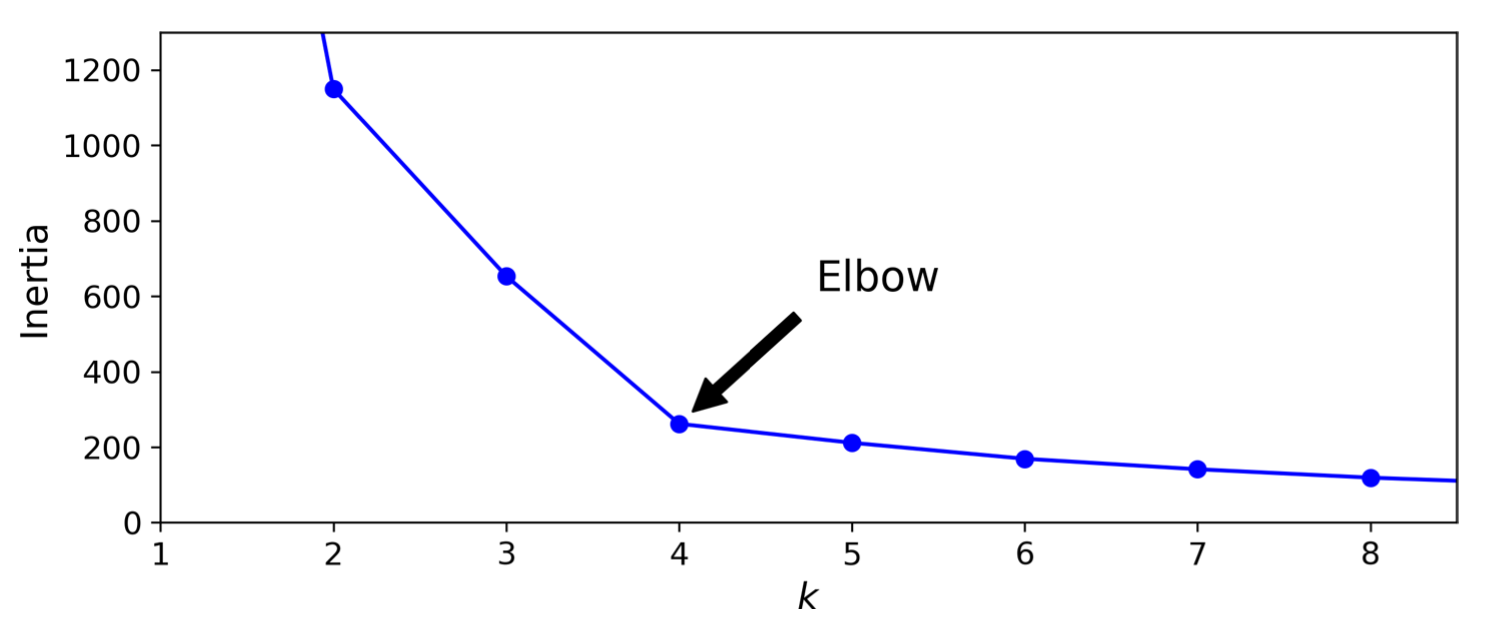

This technique for choosing the best value for the number of clusters is rather coarse. A more precise approach (but also more computationally expensive) is to use the *silhouette score*, which is the mean *silhouette coefficient* over all the instances. 

An instance’s *silhouette coefficient* is equal to $$\frac{(b-a)}{max(a, b)}$$

where *a* is the mean distance to the other instances in the same cluster (i.e., the mean intra-cluster distance) and *b* is the mean nearest-cluster distance (i.e., the mean distance to the instances of the next closest cluster, defined as the one that minimizes *b*, excluding the instance’s own cluster). 

The silhouette coefficient can vary between –1 and +1. A coefficient close to +1 means that the instance is well inside its own cluster and far from other clusters, while a coefficient close to 0 means that it is close to a cluster boundary, and finally a coefficient close to –1 means that the instance may have been assigned to the wrong cluster.

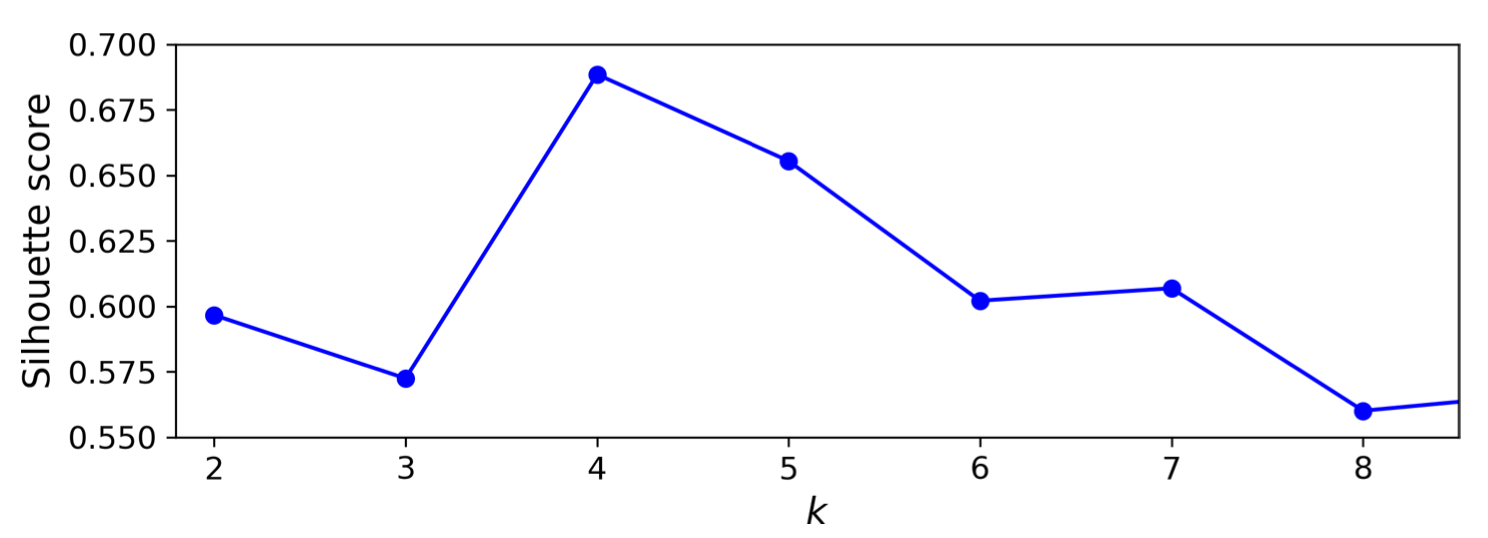

Both metrics measure diferent things and need to take into account as a guide to select the *K*. If you want to go further, take a look at this link:

https://towardsdatascience.com/elbow-method-is-not-sufficient-to-find-best-k-in-k-means-clustering-fc820da0631d

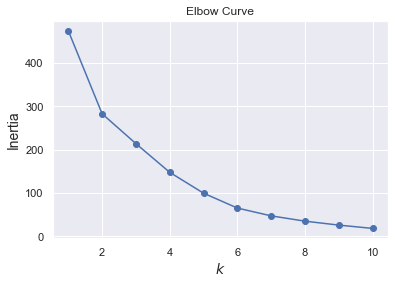

In [207]:
# let's plot the intertias to see if we can find an elbow

inertias = [model.inertia_ for model in kmeans_per_k]

plt.plot(range(1, 11), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.title('Elbow Curve')
plt.show()

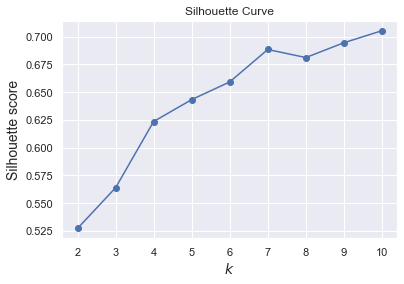

In [208]:
'''
Now, plot the sillouette
WARNING: Depending on the number of instances it could be computational expensive
For this data it would not be a problem, but take it into account if you want to use it with more data
'''

silhouette_scores = [silhouette_score(scores_svd, model.labels_)
                     for model in kmeans_per_k[1:10]] 

plt.plot(range(2, 11), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.title('Silhouette Curve')
plt.show()


## Analizing the clustering

After we select a value *k* we can start to analizing what happend inside of each cluster.

* How many instances each cluster has
* Mean values 
* Values near the centroids and outliers

Maybe we find a particular behavior or insight that lead us to select another features or *k*, that give us a better innertia, etc. Remember, it's an interative process

In [209]:
'''
As an example, let's choose 2 clusters
'''

k = 2
kmeans_k = kmeans_per_k[k-1]

# We used the vector already calculated, by if you want to do it again

#kmeans_k = KMeans(n_clusters=k, n_init=100)
#kmeans_k.fit(scores_svd)

# Let's see the predictions
y_pred_LOGS = kmeans_k.predict(scores_svd)

In [210]:
print("Number of instances on each cluster::")
for i in range(k):
    print(i,":", np.count_nonzero(y_pred_LOGS==i) )


Number of instances on each cluster::
0 : 29
1 : 39


In [211]:
'''
Let's see the mean values of each cluster
Remember, in the "features" vector we have the selected features 
and in df_LOGS all the data
'''

for cluster in range(k):
    print("\n Mean values Cluster:", cluster)
    print(df_LOGS[(y_pred_LOGS == cluster)][features].mean())


 Mean values Cluster: 0
sql_count               0.034483
2xx_count              48.034483
3xx_count               5.724138
5xx_count               1.620690
404_count            2400.862069
total_req            2456.275862
total_kbytes_sent     597.777950
dtype: float64

 Mean values Cluster: 1
sql_count             24.076923
2xx_count             13.384615
3xx_count              4.179487
5xx_count              0.000000
404_count             96.102564
total_req            113.666667
total_kbytes_sent     39.521059
dtype: float64


In [212]:
'''
Looking for the centroids!!
'''

from scipy.spatial.distance import cdist

centroids = kmeans_k.cluster_centers_
# It finds the point indexes that are centroids (or closest to)

centroids_idx = []
distances = cdist(scores_svd, centroids)

for j in range(len(centroids)):
    idx = np.argmin(distances[:,j])
    centroids_idx.append(idx)

df_centroids = df_LOGS.iloc[centroids_idx]
    
# print some data of the nearest point to the centroid
# if you want to see more, just add the print with the feature

for cluster in range(k):
    print("\nCentroid Cluster", cluster)
    print(df_centroids.iloc[cluster][features])
    print("IP: ", df_centroids.iloc[cluster]['ip'])
    print("URLs:", df_centroids.iloc[cluster]['full_url'])    
    print("UAs:", df_centroids.iloc[cluster]['full_useragent'])  



Centroid Cluster 0
sql_count                     0
2xx_count                    44
3xx_count                     3
5xx_count                     1
404_count                  2997
total_req                  3045
total_kbytes_sent    729.857422
Name: 23, dtype: object
IP:  10.73.150.78
URLs:                            get /app/vulnerabilities/exec/default_filter/ http/1.1
                                     get /app/vulnerabilities/exec/docs/ http/1.1
                                   get /app/vulnerabilities/exec/dollar/ http/1.1
                                     get /app/vulnerabilities/exec/dvwa/ http/1.1
                               get /app/vulnerabilities/exec/dvwa_email/ http/1.1
                                get /app/vulnerabilities/exec/dvwa_v1.3/ http/1.1
                                 get /app/vulnerabilities/exec/dvwapage/ http/1.1
                             get /app/vulnerabilities/exec/dvwapage.inc/ http/1.1
                                    get /app/vulnera

In [213]:
# Outliers of cluster_k

#Selected cluster
cluster_k = 0

#All points of cluster_k
scores_svd_K = scores_svd[y_pred_LOGS==cluster_k]

#Distances of each point to its centroid
distances = cdist(scores_svd_K, [kmeans_k.cluster_centers_[cluster_k]], 'euclidean')

#Lets choose the max_num fartest points
max_num = 2
idx_max = np.argsort(distances, axis=0)[-max_num:]
outliers = scores_svd_K[idx_max]

print("\n\n")
print("Detail of the fartest points of the cluster",cluster_k,":")
print("=============================================")

for out in outliers:
    index_i = np.where(scores_svd == out)[0][0]
    
    for feat in features:
        print(feat, ":", df_LOGS.iloc[index_i][feat])

    print(feat, ":", df_LOGS.iloc[index_i][feat])
    print("IP: ", df_LOGS.iloc[index_i]['ip'])
    print("URLs", df_LOGS.iloc[index_i]['full_url'])
    print("UAs", df_LOGS.iloc[index_i]['full_useragent'])
    print("\n\n")





Detail of the fartest points of the cluster 0 :
sql_count : 0
2xx_count : 100
3xx_count : 0
5xx_count : 8
404_count : 3157
total_req : 3265
total_kbytes_sent : 794.3505859375
total_kbytes_sent : 794.3505859375
IP:  10.73.150.78
URLs                              get /app/external/phpids/0.6/docs/phpdocumentor/view_source_all http/1.1
                             get /app/external/phpids/0.6/docs/phpdocumentor/vulnerabilities http/1.1
                                     get /app/external/phpids/0.6/docs/phpdocumentor/warning http/1.1
                                     get /app/external/phpids/0.6/docs/phpdocumentor/weak_id http/1.1
                                         get /app/external/phpids/0.6/docs/phpdocumentor/www http/1.1
                                       get /app/external/phpids/0.6/docs/phpdocumentor/xss_d http/1.1
                                       get /app/external/phpids/0.6/docs/phpdocumentor/xss_r http/1.1
                                       get /app/ex

In [214]:
#If we want to see one particular point of the cluster

cluster=0
pos = 6

for feat in features:
    print(feat, ":", df_LOGS[(y_pred_LOGS == cluster)].iloc[pos][feat])

print("IP: ", df_LOGS[(y_pred_LOGS == cluster)].iloc[pos]['ip'])
print("URLs:", df_LOGS[(y_pred_LOGS == cluster)].iloc[pos]['full_url'])
print("UAs:", df_LOGS[(y_pred_LOGS == cluster)].iloc[pos]['full_useragent'])


sql_count : 1
2xx_count : 67
3xx_count : 3
5xx_count : 7
404_count : 2793
total_req : 2870
total_kbytes_sent : 690.591796875
IP:  10.73.150.78
URLs:                       get /app/vulnerabilities/captcha/source/xss_s http/1.1
                          get /app/vulnerabilities/captcha/source/0 http/1.1
                        get /app/vulnerabilities/captcha/source/0.6 http/1.1
                       get /app/vulnerabilities/captcha/source/1337 http/1.1
                              get /app/vulnerabilities/csrf/pdf.asp http/1.1
                            get /app/vulnerabilities/csrf/pgsql.asp http/1.1
                    get /app/vulnerabilities/csrf/phpdocumentor.asp http/1.1
                             get /app/vulnerabilities/csrf/pdf.aspx http/1.1
                   get /app/vulnerabilities/csrf/phpdocumentor.aspx http/1.1
                           get /app/vulnerabilities/csrf/pgsql.aspx http/1.1
                              get /app/vulnerabilities/csrf/pdf.htm http/1.1
    

In [219]:
'''
If you want to initialize the clustering with specific centroids instead of leaving them at random
you just need to use the init parameter with a list of points

let's do what is in the paper, use the same centroids as the clustering before and add a new one which 
is an outlier of one of the clusters
'''

# Lets suppose we want to work with cluster=1
cluster_k = 1

# All the points of cluster 1
scores_svd_K = scores_svd[y_pred_LOGS==cluster_k]

# distance of these points to the corresponding centroid
distances = cdist(scores_svd_K, [kmeans_k.cluster_centers_[cluster_k]], 'euclidean')

# let's choose the num_max farthest points
num_max = 2
idx_max = np.argsort(distances, axis=0)[-num_max:]
outliers = scores_svd_K[idx_max]

# the old centroids
centroids = kmeans_k.cluster_centers_

# In the paper the anteultimate one was chosen because the other one was so far away that it did not group well, 
# it is left as an example and to be used as a new centroid.

outlier = outliers[-2:-1][0]
centroids_new = np.append(centroids, outlier, axis=0)

# make a new cluster with the old centroids and the new one

new_k = len(centroids_new)
kmeans_k_new = KMeans(n_clusters=new_k, init=centroids_new)
kmeans_k_new.fit(scores_svd)

predictions_new = kmeans_k_new.predict(scores_svd)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:984: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


# Things to try

Several ways of attacking the problem and analyzing and exploring the results were presented with the idea that they would be useful when looking for a solution. 
To continue, different combinations of features can be tested or new ones can be generated, to see if a better silhouette diagram can be achieved, to try other metrics, etc.

As a help for the exercise, there are only two IPs doing queries, one is the attacker and the other is just making noise. You can use this to compare the different groupings you make, obviously in real life you will not have this baseline, but it serves to emphasize that there is not a single possible path or solution, it is an iterative process that requires going back and forth many times. 


Bibliograpy: *Aurélien Géron, Hands-On Machine Learning with Scikit-Learn, Keras &TensorFlow. Third edition.*
